# Background

This notebook aims to investigate the texture difference between two ROIs.

[TOC]


In [2]:
"""Import packages"""
import re
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
import itertools
from typing import Union, Optional, List, Tuple, Any


# Algorithms

## Patch samplings

We need a function to sample equal size patches from the ROIs. The location for sampling are randomly drawn from valid coordinates. But first, we need a function that will find all valid coordinates based on a segmentaiton input. 

In [4]:

"""Define sampling functions"""
def find_square_patches(binary_mask: sitk.Image, l: int):
    """
    Identifies all square patches of size l x l within an irregular boundary
    defined by a binary mask that only has one connected component.
    
    Args:
        binary_mask (np.array): 
            A 2D numpy array representing the binary mask with a single component.
        l (int): 
            The side length of the square patches to find.

    Returns:
        list of tuple: A list of tuples, where each tuple represents the (row, column) coordinates
                       of the top-left corner of a valid l x l square patch within the boundary.
    """
    if l <= 0:
        raise ValueError("The side length l must be a positive integer.")
    
    # Check that there is only one connected component in the binary mask
    labeled_array: sitk.LabelImage = sitk.ConnectedComponent(binary_mask)
    binary_mask = sitk.GetArrayFromImage(binary_mask)

    # Get bounding box of the label
    bbox = sitk.LabelShapeStatisticsImageFilter()
    bbox.Execute(labeled_array != 0)
    bbox = bbox.GetBoundingBox(1) # [x, y, w, h]
    
    x, y, w, h = bbox
    x_end, y_end = x + w, y + h
    
    # Get coords that are non-zero
    coords_loop = np.argwhere(binary_mask != 0) # coords are y, x
    coords_loop = coords_loop[:, ::-1].tolist()
    coords_loop: set = set([tuple(c) for c in coords_loop if (c[0] <= x_end - l + 1) and (c[1] <= y_end - l + 1)])
    
    # List to store the top-left corners of valid l x l square patches
    valid_patches = []

    # Iterate from short_edge sized square back to l because bigger square must contain smaller ones
    while len(coords_loop):
        # brute force is pretty quick already
        i, j = coords_loop.pop()
        ip, jp = i+l, j+l

        patch = binary_mask[j:jp, i:ip]
        if np.all(patch != 0) and np.sum(patch):
            if not (i, j) in valid_patches:
                valid_patches.append((i, j))

    return valid_patches

# Test this function
binary_mask = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0], 
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.uint8)
binary_mask_itk = sitk.GetImageFromArray(binary_mask)

# Define the size of the square patch
side_length = 2

# Find all valid square patches
square_patches = find_square_patches(binary_mask_itk, side_length)
print(square_patches)

# timeit
# %timeit find_square_patches(binary_mask_itk, side_length)


[(4, 3), (4, 6), (9, 2), (8, 3), (2, 2), (2, 5), (1, 3), (6, 2), (4, 5), (3, 6), (5, 3), (8, 2), (9, 4), (1, 2), (7, 3), (3, 5), (5, 2), (4, 4), (8, 4), (9, 3), (2, 6), (7, 2), (6, 3)]


## Test-flight

Let's visulaize the coordinates found using this function.

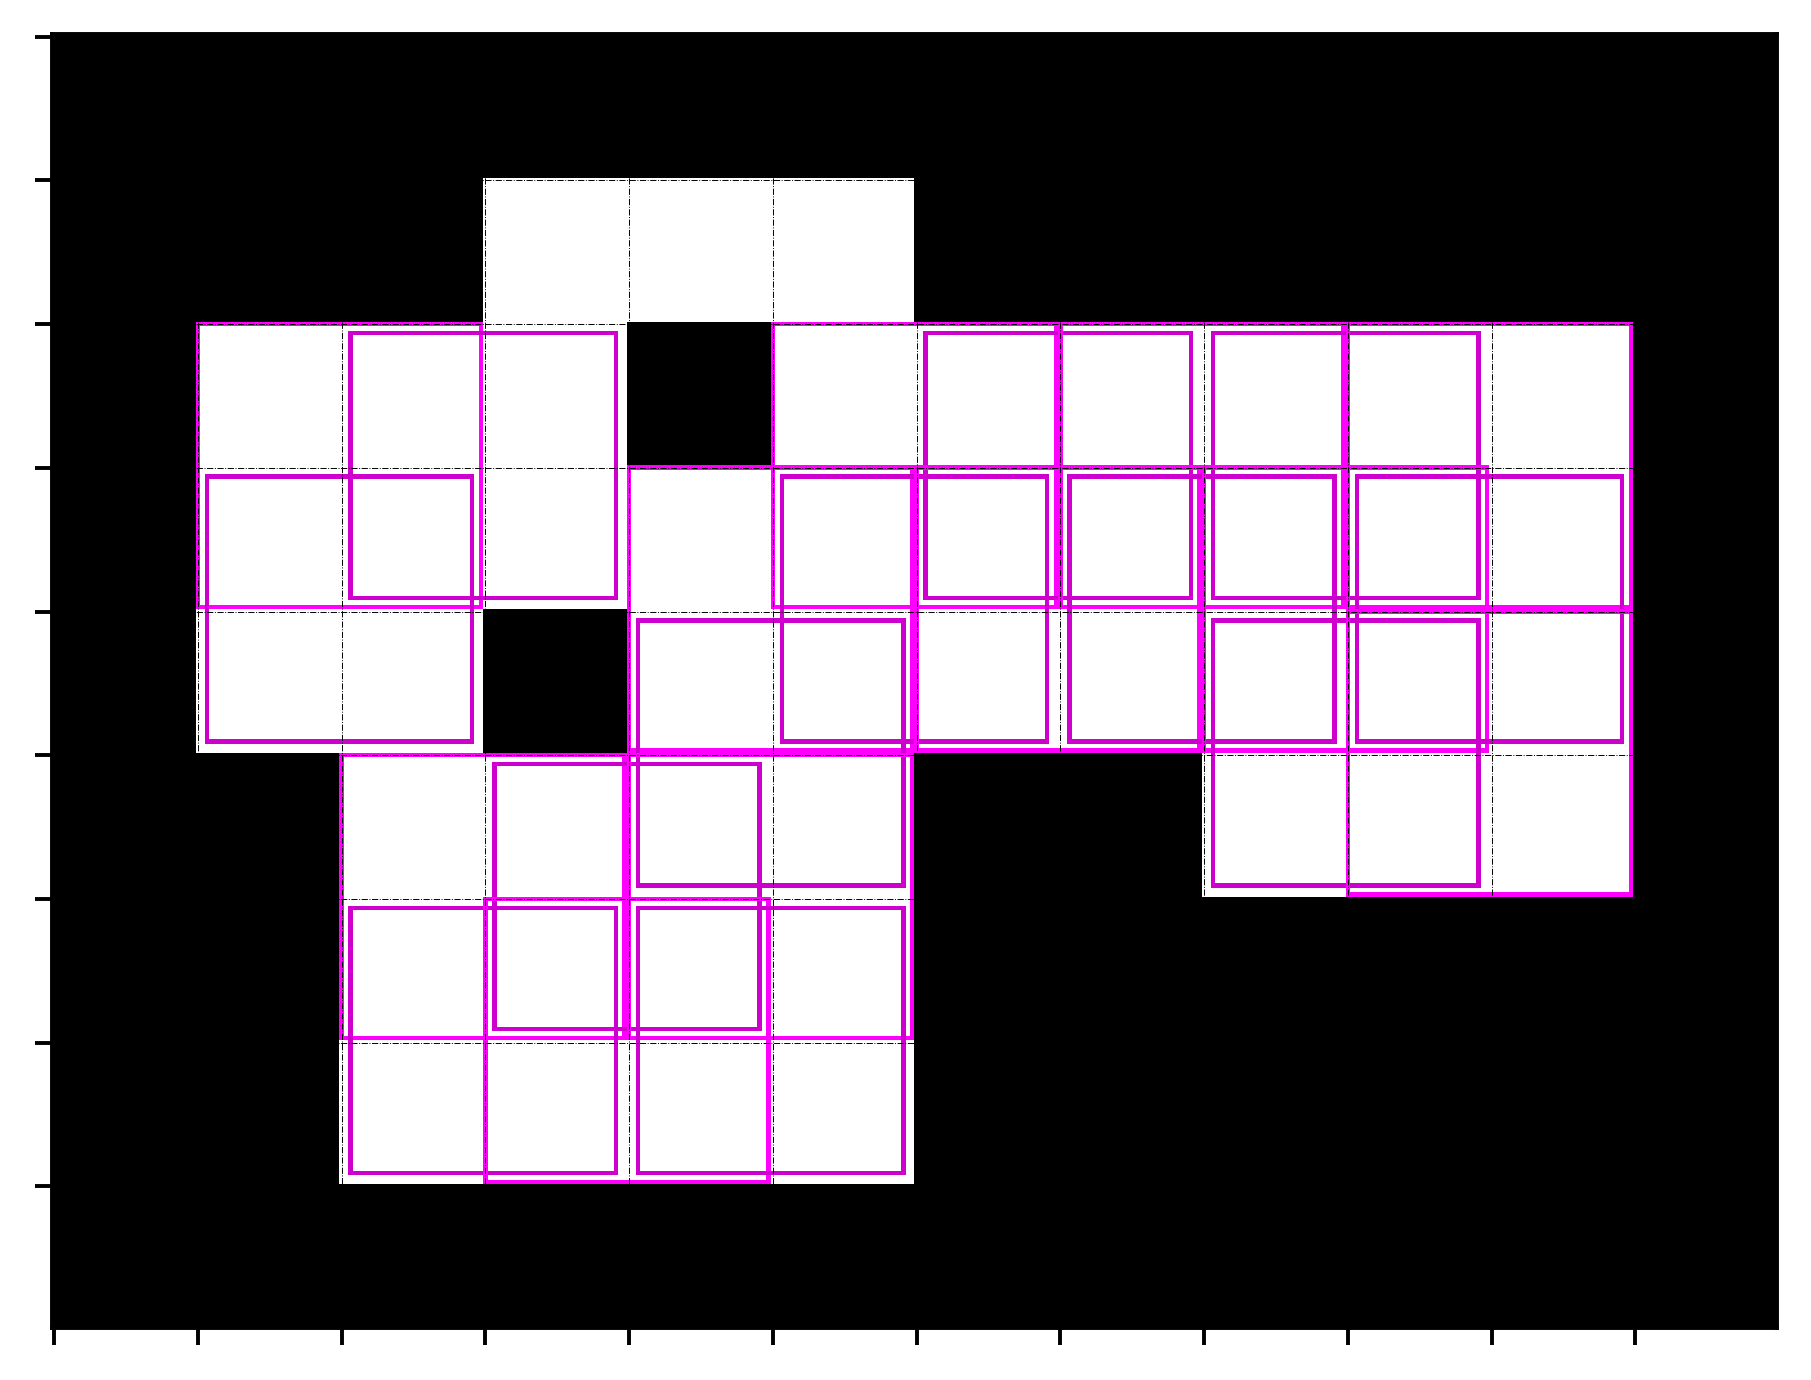

In [3]:
def visualize_bbox(im: np.ndarray, 
                   coords: np.ndarray, 
                   box_size: int, 
                   thickness: Optional[int] = 1,
                   zoom_factor: Optional[int] = 32, 
                   box_color: Optional[Tuple[int, int, int]] = (255, 0, 0)) -> np.ndarray:
    # """Draw rectangles for visualization of boxes"""
    # if zoom factor < 10, you see nothing meaningful
    if zoom_factor < 5:
        raise ArithmeticError("Zoom factor < 5 will renders output messy.")
    
    # make sure coordinates are sorted
    x = coords.sum(axis=1).argsort()
    coords = coords[x]
    
    # resize based on zoom factor
    im_out = cv2.resize(im, np.array([im.shape[1], im.shape[0]]) * zoom_factor, interpolation=cv2.INTER_NEAREST)

    # draw rectangles
    for _coords in coords:
        _coords = _coords * zoom_factor
        _box_size = box_size * zoom_factor - 1 # -1 to avoid crossing to another cell
        _thickness = thickness
        _box_color = np.array(box_color, dtype=np.uint8)

        # check if there's already a box drawn
        while all(np.isclose(im_out[_coords[1], _coords[0]], np.array(_box_color))):
            # shrink the box by 2pixels to try avoid overlap
            _coords += 2
            _box_size -= 2 * 2
            # make color a bit darker
            _box_color[_box_color != 0] -= 50
            
        im_out = cv2.rectangle(im_out, _coords, _coords + _box_size, _box_color.tolist(), _thickness)
    return im_out
    
    fig, ax = plt.subplots(1, 1, dpi=350)
    ax.imshow(im)
    for _coords in coords:
        _coords = _coords 
        _box_size = box_size # -1 to avoid crossing to another cell
        _thickness = thickness
        rect = patches.Rectangle(_coords - 0.5, box_size, box_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

zoom_factor=32
# convert this to cv2 mat
im = cv2.cvtColor(sitk.GetArrayFromImage(binary_mask_itk) * 255, cv2.COLOR_GRAY2RGB)

im = visualize_bbox(im, np.array(square_patches), side_length, zoom_factor=32, box_color=[255, 0, 255])

fig, ax = plt.subplots(1, 1, dpi=350)
ax.imshow(im)
ax.set_xticks(np.arange(0, im.shape[1], zoom_factor))
ax.set_yticks(np.arange(0, im.shape[0], zoom_factor))
ax.set_xticklabels("")
ax.set_yticklabels("")
ax.grid(color='black', linestyle='-.', linewidth=0.2)
plt.show()


## Computational Time

The complexity of the seach function is $O(n^2)$, where $n$ is proportinal to the lets pump up the input size to evaluate the time cost. As you can see, the speed isn't too bad, we are typically handling segmentation that are about $~(100\times 150)$, or even smaller than that. 

In [4]:
patch_size = 6

# Lets time this function
# first, resize the binary mask to a typical size of a lesion ~128 × 128 pixels
larger_binary_mask: np.ndarray = cv2.resize(binary_mask, np.array(binary_mask.shape) * 4, interpolation=cv2.INTER_NEAREST)
print(f"{larger_binary_mask.shape = }")
patches = find_square_patches(sitk.GetImageFromArray(larger_binary_mask), patch_size)
for_plot = larger_binary_mask
%timeit patches = find_square_patches(sitk.GetImageFromArray(larger_binary_mask), patch_size)

# first, resize the binary mask to a typical size of a lesion ~128 × 128 pixels
larger_binary_mask: np.ndarray = cv2.resize(binary_mask, np.array(binary_mask.shape) * 10, interpolation=cv2.INTER_NEAREST)
print(f"{larger_binary_mask.shape = }")
%timeit patches = find_square_patches(sitk.GetImageFromArray(larger_binary_mask), patch_size)

# first, resize the binary mask to a typical size of a lesion ~128 × 128 pixels
larger_binary_mask: np.ndarray = cv2.resize(binary_mask, np.array(binary_mask.shape) * 20, interpolation=cv2.INTER_NEAREST)
print(f"{larger_binary_mask.shape = }")
%timeit find_square_patches(sitk.GetImageFromArray(larger_binary_mask), patch_size)

larger_binary_mask.shape = (48, 36)
27 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
larger_binary_mask.shape = (120, 90)
163 ms ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
larger_binary_mask.shape = (240, 180)
2.15 s ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


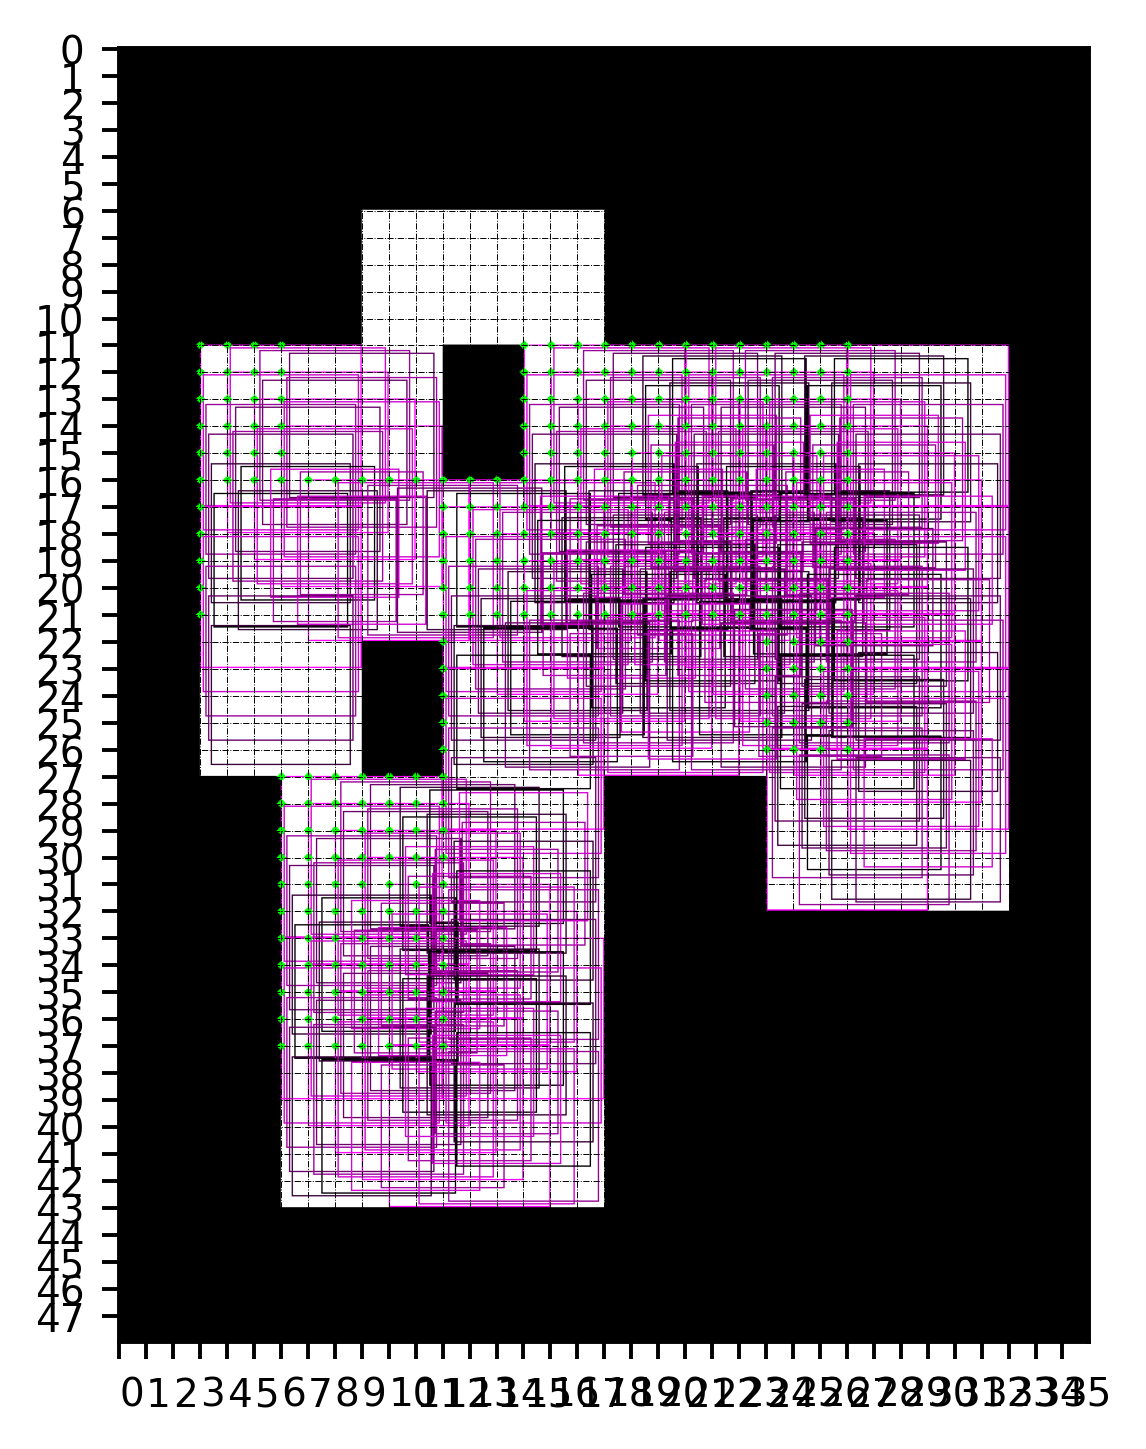

In [5]:
def draw_dots_at_coords(im, coords, zoom_factor):
    for c in coords:
        _c = np.array(c) * zoom_factor
        cv2.drawMarker(im, [_c[0], _c[1]], [0, 255, 0], markerSize=5, thickness=2)
    return im

im = cv2.cvtColor(for_plot * 255, cv2.COLOR_GRAY2RGB)
# im = cv2.drawMarker(im, [5, 10], [255, 0, 0], markerSize=1)

zoom_factor = 20
im = visualize_bbox(im, np.array(patches), patch_size, zoom_factor=zoom_factor, box_color=[255, 0, 255])
im = draw_dots_at_coords(im, patches, zoom_factor)
# show image
fig, ax = plt.subplots(1, 1, dpi=350)
ax.imshow(im)
ax.set_xticks(np.arange(0, im.shape[1], zoom_factor))
ax.set_yticks(np.arange(0, im.shape[0], zoom_factor))
ax.set_xticklabels(np.arange(0, im.shape[1] // zoom_factor), fontsize=8, ha='left')
ax.set_yticklabels(np.arange(0, im.shape[0] // zoom_factor), fontsize=8)
ax.grid(color='black', linestyle='-.', linewidth=0.2)
plt.show()
# print(patches)

# Texture extraction

Now we are aiming to extract patches with a size of $(16\times 16)$, the patch isn't very large so we want to utlize the most out of it. With this size, the kernel of filters should be no larger than $3\times 3$. 

## Using pyradiomics

The extraction will use [mradtk](https://github.com/alabamagan/mri_radiomics_toolkit/tree/pre_release). The installation instruction is on the github repo. Now, pyradiomics requires specification of an ROI for each input, which we don't need since the entire patch is considered. Therefore, a wrapper function is written to create a full mask from each patch. 

Furthermore, the pyradiomcis also specifies a spacing resampling and rebinning process. Once again, these steps are "skipped" by specifying dummy attributes and stripping the patch of their original spacing, treating them as unit spacing patches. This setting will only affect the shape feature calcualtion and certain imaging filters that takes in a radius as argument.

## Import Library

In [6]:
import SimpleITK as sitk
import pandas as pd
import radiomics
import mri_radiomics_toolkit as mradtk
from pathlib import Path

#* Echo versions
versions = {
    'sitk': sitk.__version__, 
    'pandas': pd.__version__, 
    'Pyradiomics': radiomics.__version__, 
}
print(versions)

/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'sitk': '2.3.1', 'pandas': '2.2.1', 'Pyradiomics': 'v3.1.0'}


## Try on a single case

### Getting tumor patches

im_slice.GetSize() = (183, 136); np_im_slice.shape = (136, 183)


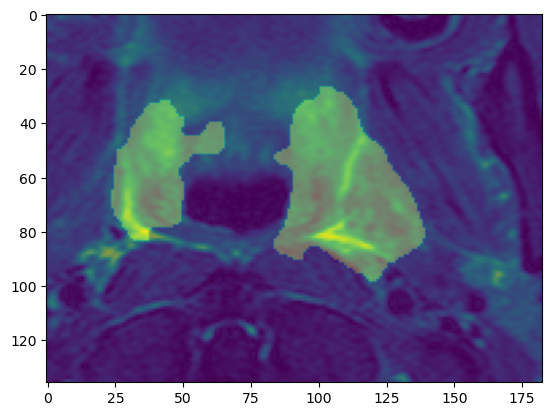

patch_stack.shape = (946, 16, 16)


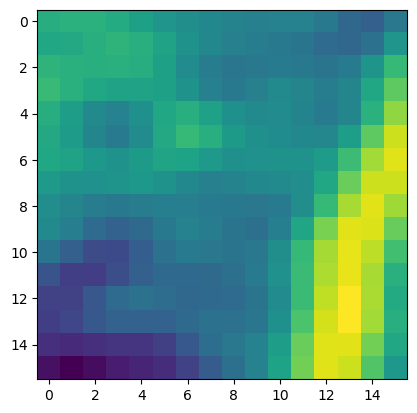

In [7]:

# * Load data first
case_im = Path("../NPC_Segmentation/72.RecurrentData/StudyFilesBySequence/Pre/T2W-FS_TRA/FU101-Pre-T2_FS_TRA.nii.gz/")
case_seg = Path("../NPC_Segmentation/72.RecurrentData/StudyFilesBySequence/Segment/T2W-FS_TRA/FU101-Pre-T2_FS_TRA.nii.gz/")

assert case_im.is_file()
assert case_seg.is_file()

# * Load images
im = sitk.ReadImage(str(case_im))
seg = sitk.ReadImage(str(case_seg))

# * Preprocess
# Binarilize
seg = sitk.VotingBinaryHoleFilling(seg != 0)

# * Get patches
# Get bbox and select the center slice
lab_stat_filter = sitk.LabelShapeStatisticsImageFilter()
lab_stat_filter.Execute(seg)
x, y, z, w, h, d= lab_stat_filter.GetBoundingBox(1)

# Narrow down to middle slice
im_slice  = im[x-10:x+w+10, y-10:y+h+10, z + d //2]
seg_slice = seg[x-10:x+w+10, y-10:y+h+10, z + d //2]

# numpy version 
np_im_slice = sitk.GetArrayFromImage(im_slice)
np_seg_slice = sitk.GetArrayFromImage(seg_slice)

#! Note the tranpose of x, y
print(f"{im_slice.GetSize() = }; {np_im_slice.shape = }")

plt.imshow(np_im_slice)
plt.imshow(np_seg_slice, alpha=0.3)
plt.show()

# Get all possible squares with correct size
patch_size = 16 # px
patches = find_square_patches(seg_slice, patch_size)
patches = np.array(patches)

# Extract patches from original images
patch_stack = np.stack([np_im_slice[j:j+patch_size, i:i+patch_size] for i, j in patches])
print(f"{patch_stack.shape = }")

# Plot
fig, ax = plt.subplots(1, 1)
ax.imshow(patch_stack[0])
plt.show()


### Get some non-malignant patches

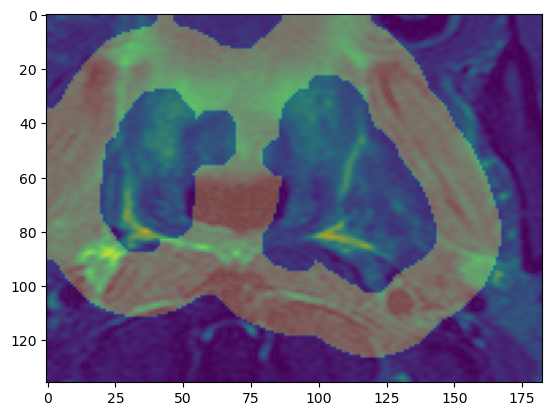

non_ca_patch_stack.shape = (2263, 16, 16)


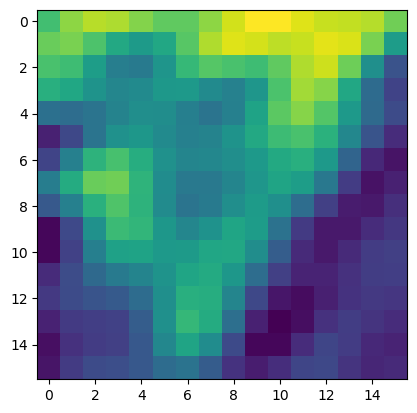

In [8]:

# * Dilate the patches for ~1.5 * patch_size for vicinity non-cancer tissues
seg_dilated = sitk.BinaryDilate(seg_slice, kernelRadius = [int(patch_size * 2), int(patch_size*2)])
seg_non_cancer = seg_dilated - seg_slice
# Shirnks it a bit so it stays further away from the cancer
seg_non_cancer = sitk.BinaryErode(seg_non_cancer, kernelRadius = [patch_size // 4, patch_size // 4])

# Lets see what this looks like
np_non_cancer_slice = sitk.GetArrayFromImage(seg_non_cancer)
plt.imshow(np_im_slice)
plt.imshow(np_non_cancer_slice, alpha=0.3)
plt.show()

# * Extract patches from it
non_cancer_patches = find_square_patches(seg_non_cancer, patch_size)
non_ca_patch_stack = np.stack([np_im_slice[j:j+patch_size, i:i+patch_size] for i, j in non_cancer_patches])

print(f"{non_ca_patch_stack.shape = }")

# Plot
fig, ax = plt.subplots(1, 1)
ax.imshow(non_ca_patch_stack[0])
plt.show()


### Extract patch textures for each patches

In [9]:

# Save the stacks as sitk images
sitk_patch_stack = sitk.GetImageFromArray(patch_stack)
sitk_non_ca_patch_stack = sitk.GetImageFromArray(non_ca_patch_stack)
sitk.WriteImage(sitk_patch_stack, "_temp/img/CA01_patches.nii.gz")
sitk.WriteImage(sitk_non_ca_patch_stack, "_temp/img/NCA01_patches.nii.gz")

# Create dummy segmentation 
s1 = sitk.BinaryThreshold(sitk_patch_stack, -1E10, 1E10)
ns1 = sitk.BinaryThreshold(sitk_non_ca_patch_stack, -1E10, 1E10)
sitk.WriteImage(s1, "_temp/seg/CA01_patches.nii.gz")
sitk.WriteImage(ns1, "_temp/seg/NCA01_patches.nii.gz")


[2024-03-13 22:25:50,289-INFO] (global) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
[2024-03-13 22:25:50,289-INFO] (global) Created first logger. Exception hooked to this logger. Log level is: info
[2024-03-13 22:25:50,289-INFO] (default) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
[2024-03-13 22:25:50,289-INFO] (default) Requesting logger [FeatureExtractor] not exist, creating...
[2024-03-13 22:25:50,289-INFO] (FeatureExtractor) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
[2024-03-13 22:25:50,290-INFO] (default) Requesting logger [radiomics_features] not exist, creating...
[2024-03-13 22:25:50,290-INFO] (radiomics_features) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
[2024-03-13 22:25:50,291-INFO] (default) Requesting logger [algorithm.utils] not exist, creating...
[2024-03-13 22:25:50,291-INFO] (algorit

[2024-03-13 22:25:50,972-INFO] (radiomics_features) Extracting feature...


[2024-03-13 22:25:50,987-INFO] (radiomics_features) Extracting feature...


Feature extraction:   0%|          | 0/2 [00:00<?, ?it/s]Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
Feature extraction:   0%|          | 0/2 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be c

KeyboardInterrupt: 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Image too small to apply LoG filter, size: [16 16  1]
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Image too small to apply LoG filter, size: [16 16  1]
GLCM is symmetrical, therefore Sum Average = 2 * Joint Ave

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Image too small to apply LoG filter, size: [16 16  1]
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Image too small to apply LoG filter, size: [16 16  1]
GLCM is symmetrical, therefore Sum Average = 2 * Joint Ave

In [1]:
import mri_radiomics_toolkit as mradtk
import radiomics
import logging
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from pathlib import Path


# mute pyrad's annoying logger that info instead of warn
radiomics.logger.setLevel(logging.ERROR)

# fe = mradtk.FeatureExtractor(id_globber=r"[A-Z]+[0-9]+", param_file="./assets/pyrad_settings.yml", by_slice=1)
# df = fe.extract_features(Path("_temp/img"), Path("_temp/seg"), by_slice=2)
# df

/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Some statistical analysis

Now lets see which features shows significant differences between non-tumor and tumor patches.

In [20]:
from scipy import stats
import pandas as pd
warnings.filterwarnings('ignore', pd.errors.PerformanceWarning)

df_ca = df.loc['CA01'].copy()
df_nca = df.loc['NCA01'].copy()
# Drop metadata that are not features
df_ca.drop('diagnostics', axis=1, inplace=True)
df_nca.drop('diagnostics', axis=1, inplace= True)

# * compare each feature (colums)
rows = []
for col in df_ca.columns:
    f, pval = stats.ttest_ind(df_ca[col].values.astype('float'), df_nca[col].values.astype('float'))
    row = pd.Series({
        'p-val': pval, 
        'f': f
    }, name=col)
    rows.append(row)
df_stat = pd.concat(rows, axis=1).T
df_stat[df_stat['p-val'] > .05]

/tmp/ipykernel_828111/1358091262.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_ca.drop('diagnostics', axis=1, inplace=True)
/tmp/ipykernel_828111/1358091262.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_nca.drop('diagnostics', axis=1, inplace= True)
/home/lwong/Toolkits/Anaconda/envs/texture-vision/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


p-val         f
original    glcm  Autocorrelation               0.054829  1.920928
                  Id                            0.056309 -1.909326
                  Idm                           0.064699 -1.847966
                  JointAverage                  0.218226  1.231499
                  SumAverage                    0.218226  1.231499
            glrlm HighGrayLevelRunEmphasis      0.084158  1.727591
                  LongRunHighGrayLevelEmphasis  0.179185  1.343562
lbp-2D      glcm  JointEnergy                   0.439506 -0.773124
                  JointEntropy                  0.756848 -0.309649
            glrlm LongRunLowGrayLevelEmphasis   0.814687 -0.234403
gradient    glcm  ClusterProminence             0.359959  0.915575
                  DifferenceAverage             0.614001  0.504420
                  Idn                           0.050396 -1.957324
                  InverseVariance               0.208568  1.257765
exponential glcm  InverseVariance               0.316780 -1.001254
                  MaximumProbability            0.080212 -1.750013

# Conclusion

As you can see in this case, with only the segmentation of one case we can already generate such many patches and texture features. Regardless, more patches has pros and cons and can challenge the interpretation of statistical analysis. 

Maher et al. (CBE Life Sci Educ, 2013) wrote an eassay that discuss issues related with an inflation in sample size in a statistical analysis, stressing the phenomonon where there will be a more significant p-value when there are more samples because of the shrink in variances. Now this becomes a problem becuase you might find two group with a very close mean having a very significant p-value, just because there's a huge sample size. How should we interpret the result in this case?